In [6]:
%load_ext autoreload
%autoreload 2

import os
from tqdm import tqdm_notebook as tqdm

import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers

import cv2

from core.layers import Downsampler, Upsampler, Skip
from core.losses import pixelwise_mse
from core.utils import crop_div_32

import imageio
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


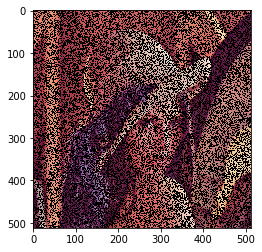

In [2]:
INPUT_IMG_PATH = "data/lena.png"
OUTPUT_IMG_NAME = os.path.splitext(os.path.basename(INPUT_IMG_PATH))[0]
OUTPUT_DIR = "output/image_reconstruction"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

img = imageio.imread(INPUT_IMG_PATH)
img = crop_div_32(img)


mask = np.random.choice([0, 255], img.shape[:2], [0.5, 0.5])
img = cv2.bitwise_and(img, img, mask=mask.astype(np.uint8))

img = tf.image.convert_image_dtype(img, dtype=tf.float32)
plt.imshow(img)

In [3]:
num_filters_down = [128, 128, 128, 128, 128]
ksizes_down = [3, 3, 3, 3, 3]

num_filters_up = num_filters_down
ksizes_up = ksizes_down

num_filters_skip = [4, 4, 4, 4, 4]
ksizes_skip = [1, 1, 1, 1, 1]

sigma_p = 1/30
n_iter = 11000
lr = 0.001
upsampling_mode = "bilinear"

In [4]:
skip_outputs = [None] * len(num_filters_skip)
model_input = layers.Input(shape=img.shape[:2] + (32,), dtype=tf.float32)
x = model_input

for i in range(len(num_filters_down)):
    x = Downsampler(num_filters_down[i],
                    ksizes_down[i])(x)
    if num_filters_skip[i]:
        skip_outputs[i] = Skip(num_filters_skip[i], ksizes_skip[i])(x)

    
for i in range(len(num_filters_up) - 1, -1, -1):
    if num_filters_skip[i]:
        x = tf.concat((x, skip_outputs[i]), axis=3)
    x = Upsampler(num_filters_up[i],
                  ksizes_up[i],
                  scale_factor=2,
                  upsampling_mode=upsampling_mode)(x)

    
# Transform to original 3-channel image
model_output = layers.Conv2D(filters=3, kernel_size=1, 
                             strides=1, padding='SAME', 
                             activation='sigmoid')(x)
model = models.Model(inputs=model_input, outputs=model_output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 32 0                                            
__________________________________________________________________________________________________
downsampler (Downsampler)       (None, 256, 256, 128 185600      input_1[0][0]                    
__________________________________________________________________________________________________
downsampler_1 (Downsampler)     (None, 128, 128, 128 296192      downsampler[0][0]                
__________________________________________________________________________________________________
downsampler_2 (Downsampler)     (None, 64, 64, 128)  296192      downsampler_1[0][0]              
______________________________________________________________________________________________

In [5]:
opt = optimizers.Adam(lr=lr)

z = np.random.uniform(0, 0.1, img.shape[:2] + (32,))
z = np.expand_dims(z, axis=0)
y_true = np.expand_dims(img, axis=0)
loss_vals = []

for it in tqdm(range(1, n_iter + 1)):
    with tf.GradientTape() as tape:
        y_pred = model(z, training=True)
        main_loss = pixelwise_mse(y_true, y_pred)
        loss_vals.append(main_loss.numpy())
        loss = tf.add_n([main_loss] + model.losses)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    # Add perturb noise to z
    z += np.random.randn(*z.shape) * sigma_p
    if it % 500 == 0 or it == 1:
        print(f"Iter {it}: loss={loss.numpy()}")
        output_img = tf.image.convert_image_dtype(tf.squeeze(y_pred), dtype=tf.uint8).numpy()
        output_path = os.path.join(OUTPUT_DIR, f"{OUTPUT_IMG_NAME}_{it}.jpg")
        imageio.imsave(output_path, output_img)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iter 1: loss=[0.20392191]


KeyboardInterrupt: 